In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
cd "./drive/MyDrive/Colab Notebooks/CS492I_DL/Project"

/content/drive/MyDrive/Colab Notebooks/CS492I_DL/Project


In [ ]:
# cd reconstructing_faces_from_voices/
! pwd

/content/drive/MyDrive/Colab Notebooks/CS492I_DL/Project


In [ ]:
# ! . install.sh

# Train code

In [ ]:
import os
import time
import torch
import torch.nn.functional as F

from torch.utils.data import DataLoader
from config import DATASET_PARAMETERS, NETWORKS_PARAMETERS
from parse_dataset import get_dataset
from utils import Meter, cycle, save_model


In [ ]:
### config

import string
from dataset import VoiceDataset, FaceDataset
from network import VoiceEmbedNet, Generator, FaceEmbedNet, Classifier
from utils import get_collate_fn

DATASET_PARAMETERS = {
    # meta data provided by voxceleb1 dataset
    'meta_file': 'data/vox1_meta.csv',

    # voice dataset
    'voice_dir': 'data/sample_voices',
    'voice_ext': 'npy',

    # face dataset
    'face_dir': 'data/sample_images',
    'face_ext': '.jpg',

    # train data includes the identities
    # whose names start with the characters of 'FGH...XYZ' 
    'split': string.ascii_uppercase[:],

    # dataloader
    'voice_dataset': VoiceDataset,
    'face_dataset': FaceDataset,
    'batch_size': 128,
    'nframe_range': [300, 800],
    'workers_num': 1,
    'collate_fn': get_collate_fn,

    # test data
    'test_data': 'data/test_data/'
}


NETWORKS_PARAMETERS = {
    # VOICE EMBEDDING NETWORK (e)
    'e': {
        'network': VoiceEmbedNet,
        'input_channel': 64,
        'channels': [256, 384, 576, 864],
        'output_channel': 64, # the embedding dimension
        'model_path': 'pretrained_models/voice_embedding.pth',
    },
    # GENERATOR (g)
    'g': {
        'network': Generator,
        'input_channel': 64,
        'channels': [1024, 512, 256, 128, 64], # channels for deconvolutional layers
        'output_channel': 3, # images with RGB channels
        'model_path': 'models/generator.pth',
    },
    # FACE EMBEDDING NETWORK (f)
    'f': {
        'network': FaceEmbedNet,
        'input_channel': 3,
        'channels': [32, 64, 128, 256, 512],
        'output_channel': 64,
        'model_path': 'models/face_embedding.pth',
    },
    # DISCRIMINATOR (d)
    'd': {
        'network': Classifier, # Discrminator is a special Classifier with 1 subject
        'input_channel': 64,
        'channels': [],
        'output_channel': 1,
        'model_path': 'models/discriminator.pth',
    },
    # CLASSIFIER (c)
    'c': {
        'network': Classifier,
        'input_channel': 64,
        'channels': [],
        'output_channel': -1, # This parameter is depended on the dataset we used
        'model_path': 'models/classifier.pth',
    },
    # OPTIMIZER PARAMETERS 
    'lr': 0.0002,
    'beta1': 0.5,
    'beta2': 0.999,

    # MODE, use GPU or not
    'GPU': True,
}

In [ ]:
#### Dataloader


import os

def parse_metafile(meta_file):
    with open(meta_file, 'r') as f:
        lines = f.readlines()[1:]
    celeb_ids = {}
    for line in lines:
        ID, name, _, _, _ = line.rstrip().split('\t')
        celeb_ids[ID] = name
    return celeb_ids

def get_labels(voice_list, face_list):
    voice_names = {item['name'] for item in voice_list}
    face_names = {item['name'] for item in face_list}
    names = voice_names & face_names

    voice_list = [item for item in voice_list if item['name'] in names]
    face_list = [item for item in face_list if item['name'] in names]

    names = sorted(list(names))
    label_dict = dict(zip(names, range(len(names))))
    for item in voice_list+face_list:
        item['label_id'] = label_dict[item['name']]
    return voice_list, face_list, len(names)
    

def get_dataset_files(data_dir, data_ext, celeb_ids, split):
    data_list = []
    # read data directory
    print(data_dir)
    for root, dirs, filenames in os.walk(data_dir):
        for filename in filenames:
            if filename.endswith(data_ext):
                filepath = os.path.join(root, filename)
                # so hacky, be careful! 
                # print('filepath', filepath[len(data_dir):])
                folder = filepath[len(data_dir):].split('/')[1]
                celeb_name = celeb_ids.get(folder, folder)
                if celeb_name.startswith(tuple(split)):
                    data_list.append({'filepath': filepath, 'name': celeb_name})
    return data_list

def get_dataset(data_params):
    celeb_ids = parse_metafile(data_params['meta_file'])
    print('celeb ids', celeb_ids)
    voice_list = get_dataset_files(data_params['voice_dir'],
                                   data_params['voice_ext'],
                                   celeb_ids,
                                   data_params['split'])
    face_list = get_dataset_files(data_params['face_dir'],
                                  data_params['face_ext'],
                                  celeb_ids,
                                  data_params['split'])
    
    print("Voice: ", voice_list)
    print('Face: ', face_list)
    return get_labels(voice_list, face_list)

In [ ]:

# dataset and dataloader
print('Parsing your dataset...')
voice_list, face_list, id_class_num = get_dataset(DATASET_PARAMETERS)
NETWORKS_PARAMETERS['c']['output_channel'] = id_class_num
print ('Done parsing dataset.')

Parsing your dataset...
celeb ids {'id10001': 'A.J._Buckley', 'id10002': 'A.R._Rahman', 'id10003': 'Aamir_Khan', 'id10004': 'Aaron_Tveit', 'id10005': 'Aaron_Yoo', 'id10006': 'Abbie_Cornish', 'id10007': 'Abigail_Breslin', 'id10008': 'Abigail_Spencer', 'id10009': 'Adam_Beach', 'id10010': 'Adam_Brody', 'id10011': 'Adam_Copeland', 'id10012': 'Adam_Driver', 'id10013': 'Adrianne_Curry', 'id10014': 'Adrianne_Palicki', 'id10015': 'Agyness_Deyn', 'id10016': 'Aidan_Turner', 'id10017': 'Ajay_Devgn', 'id10018': 'Akshay_Kumar', 'id10019': 'Alain_Delon', 'id10020': 'Alan_Alda', 'id10021': 'Alan_Cumming', 'id10022': 'Alan_Rickman', 'id10023': 'Alan_Tudyk', 'id10024': 'Alba_Rohrwacher', 'id10025': 'Aldis_Hodge', 'id10026': 'Alex_Borstein', 'id10027': 'Alex_Kingston', 'id10028': 'Alex_Pettyfer', 'id10029': 'Alex_Trebek', 'id10030': 'Alexa_Davalos', 'id10031': 'Alexander_Siddig', 'id10032': 'Alexandra_Daddario', 'id10033': 'Alexandra_Roach', 'id10034': 'Alexz_Johnson', 'id10035': 'Alfre_Woodard', 'id100

In [ ]:
DATASET_PARAMETERS['batch_size'] = 8

print('Preparing the datasets...')
voice_dataset = DATASET_PARAMETERS['voice_dataset'](voice_list,
                               DATASET_PARAMETERS['nframe_range'])
face_dataset = DATASET_PARAMETERS['face_dataset'](face_list)

print('Preparing the dataloaders...')
collate_fn = DATASET_PARAMETERS['collate_fn'](DATASET_PARAMETERS['nframe_range'])
voice_loader = DataLoader(voice_dataset, shuffle=True, drop_last=True,
                          batch_size= DATASET_PARAMETERS['batch_size'],
                          num_workers=DATASET_PARAMETERS['workers_num'],
                          collate_fn=collate_fn)
face_loader = DataLoader(face_dataset, shuffle=True, drop_last=True,
                         batch_size=DATASET_PARAMETERS['batch_size'],
                         num_workers=DATASET_PARAMETERS['workers_num'])

voice_iterator = iter(cycle(voice_loader))
face_iterator = iter(cycle(face_loader))


Preparing the datasets...
Preparing the dataloaders...


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class VoiceEmbedNet(nn.Module):
    def __init__(self, input_channel, channels, output_channel):
        super(VoiceEmbedNet, self).__init__()
        self.model = nn.Sequential(
            nn.Conv1d(input_channel, channels[0], 3, 2, 1, bias=False),
            nn.BatchNorm1d(channels[0], affine=True),
            nn.ReLU(inplace=True),
            nn.Conv1d(channels[0], channels[1], 3, 2, 1, bias=False),
            nn.BatchNorm1d(channels[1], affine=True),
            nn.ReLU(inplace=True),
            nn.Conv1d(channels[1], channels[2], 3, 2, 1, bias=False),
            nn.BatchNorm1d(channels[2], affine=True),
            nn.ReLU(inplace=True),
            nn.Conv1d(channels[2], channels[3], 3, 2, 1, bias=False),
            nn.BatchNorm1d(channels[3], affine=True),
            nn.ReLU(inplace=True),
            nn.Conv1d(channels[3], output_channel, 3, 2, 1, bias=True),
        )

    def forward(self, x):
        x = self.model(x)
        x = F.avg_pool1d(x, x.size()[2], stride=1)
        x = x.view(x.size()[0], -1, 1, 1)
        return x

class Generator(nn.Module):
    def __init__(self, input_channel, channels, output_channel):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(input_channel, channels[0], 4, 1, 0, bias=True),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(channels[0], channels[1], 4, 2, 1, bias=True),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(channels[1], channels[2], 4, 2, 1, bias=True),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(channels[2], channels[3], 4, 2, 1, bias=True),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(channels[3], channels[4], 4, 2, 1, bias=True),
            nn.ReLU(inplace=True),
            # nn.ConvTranspose2d(channels[4], channels[5], 4, 2, 1, bias=True),
            # nn.ReLU(inplace=True),
            # nn.ConvTranspose2d(channels[5], channels[5], 4, 2, 1, bias=True),
            # nn.ReLU(inplace=True),
            nn.ConvTranspose2d(channels[4], output_channel, 1, 1, 0, bias=True),
        )
    def forward(self, x):
        x = self.model(x)
        return x

class FaceEmbedNet(nn.Module):
    def __init__(self, input_channel, channels, output_channel):
        super(FaceEmbedNet, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_channel, channels[0], 1, 1, 0, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(channels[0], channels[1], 4, 2, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(channels[1], channels[2], 4, 2, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(channels[2], channels[3], 4, 2, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(channels[3], channels[4], 4, 2, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(channels[4], output_channel, 4, 1, 0, bias=True),
        )
 
    def forward(self, x):
        x = self.model(x)
        return x

class Classifier(nn.Module):
    def __init__(self, input_channel, channels, output_channel):
        super(Classifier, self).__init__()
        self.model = nn.Sequential ( 
            nn.Linear(input_channel, 256, bias=False),
            nn.Linear(256, output_channel, bias=False)
        )


    def forward(self, x):
        x = x.view(x.size()[0], -1)
        x = self.model(x)
        return x

def get_network(net_type, params, train=True):
    net_params = params[net_type]
    net = net_params['network'](net_params['input_channel'],
                                net_params['channels'],
                                net_params['output_channel'])

    if params['GPU']:
        net.cuda()

    if train:
        net.train()
        optimizer = optim.Adam(net.parameters(),
                               lr=params['lr'],
                               betas=(params['beta1'], params['beta2']))
    else:
        net.eval()
        net.load_state_dict(torch.load(net_params['model_path']))
        optimizer = None
    return net, optimizer


In [ ]:
NETWORKS_PARAMETERS = {
    # VOICE EMBEDDING NETWORK (e)
    'e': {
        'network': VoiceEmbedNet,
        'input_channel': 64,
        'channels': [256, 384, 576, 864],
        'output_channel': 64, # the embedding dimension
        'model_path': 'pretrained_models/voice_embedding.pth',
    },

    # Paper's G
    'g': {
        'network': Generator,
        'input_channel': 64,
        'channels': [1024, 512, 256, 128, 64], # channels for deconvolutional layers
        'output_channel': 3, # images with RGB channels
        'model_path': 'pretrained_models/generator.pth',
    },

    # GENERATOR (g)
    # 'g': {
    #     'network': Generator,
    #     'input_channel': 64,
    #     'channels': [2048, 1024, 512, 256, 128], # channels for deconvolutional layers
    #     # 'channels': [1024, 512, 256, 128, 64], # channels for deconvolutional layers

    #     'output_channel': 3, # images with RGB channels
    #     'model_path': 'pretrained_models/generator.pth',
    # },
    # FACE EMBEDDING NETWORK (f)
    'f': {
        'network': FaceEmbedNet,
        'input_channel': 3,
        'channels': [32, 64, 128, 256, 512],
        'output_channel': 64,
        'model_path': 'models/face_embedding.pth',
    },
    # DISCRIMINATOR (d)
    'd': {
        'network': Classifier, # Discrminator is a special Classifier with 1 subject
        'input_channel': 64,
        'channels': [],
        'output_channel': 1,
        'model_path': 'models/discriminator.pth',
    },
    # CLASSIFIER (c)
    'c': {
        'network': Classifier,
        'input_channel': 64,
        'channels': [],
        'output_channel': -1, # This parameter is depended on the dataset we used
        'model_path': 'models/classifier.pth',
    },
    'temp_gen': {
        'network': Generator,
        'input_channel': 64,
        'channels': [2048, 1024, 512, 256, 128], # channels for deconvolutional layers

        'output_channel': 3, # images with RGB channels
        'model_path': './david_model',
    },
    # OPTIMIZER PARAMETERS 
    'lr': 0.0002,
    'beta1': 0.5,
    'beta2': 0.999,

    # MODE, use GPU or not
    'GPU': True,
}
NETWORKS_PARAMETERS['c']['output_channel'] = id_class_num


In [ ]:
# networks, Fe, Fg, Fd (f+d), Fc (f+c)
print('Initializing networks...')
e_net, e_optimizer = get_network('e', NETWORKS_PARAMETERS, train=False)
g_net, g_optimizer = get_network('g', NETWORKS_PARAMETERS, train=True)
f_net, f_optimizer = get_network('f', NETWORKS_PARAMETERS, train=True)
d_net, d_optimizer = get_network('d', NETWORKS_PARAMETERS, train=True)
c_net, c_optimizer = get_network('c', NETWORKS_PARAMETERS, train=True)

# Meters for recording the training status
iteration = Meter('Iter', 'sum', ':5d')
data_time = Meter('Data', 'sum', ':4.2f')
batch_time = Meter('Time', 'sum', ':4.2f')
D_real = Meter('D_real', 'avg', ':3.2f')
D_fake = Meter('D_fake', 'avg', ':3.2f')
C_real = Meter('C_real', 'avg', ':3.2f')
GD_fake = Meter('G_D_fake', 'avg', ':3.2f')
GC_fake = Meter('G_C_fake', 'avg', ':3.2f')

Initializing networks...


In [ ]:
# label for real/fake faces
real_label = torch.full((DATASET_PARAMETERS['batch_size'], 1), 1)
fake_label = torch.full((DATASET_PARAMETERS['batch_size'], 1), 0)

In [ ]:
print('Training models...')
for it in range(15000):
    # data
    start_time = time.time()

    
    voice, voice_label = next(voice_iterator)

    face, face_label = next(face_iterator)

    noise = 0.05*torch.randn(DATASET_PARAMETERS['batch_size'], 64, 1, 1)

    # use GPU or not
    if NETWORKS_PARAMETERS['GPU']: 
        voice, voice_label = voice.cuda(), voice_label.cuda()
        face, face_label = face.cuda(), face_label.cuda()
        real_label, fake_label = real_label.cuda(), fake_label.cuda()
        noise = noise.cuda()
    data_time.update(time.time() - start_time)

    # get embeddings and generated faces
    embeddings = e_net(voice)
    embeddings = F.normalize(embeddings)
    # introduce some permutations
    embeddings = embeddings + noise
    embeddings = F.normalize(embeddings)
    fake = g_net(embeddings)

    # Discriminator
    f_optimizer.zero_grad()
    d_optimizer.zero_grad()
    c_optimizer.zero_grad()
    real_score_out = d_net(f_net(face))
    fake_score_out = d_net(f_net(fake.detach()))
    real_label_out = c_net(f_net(face))
    # print(torch.sigmoid(real_score_out).type(torch.LongTensor), real_label.type())
    D_real_loss = F.binary_cross_entropy(torch.sigmoid(real_score_out).to('cuda'), real_label.type(torch.float).to('cuda'))
    D_fake_loss = F.binary_cross_entropy(torch.sigmoid(fake_score_out).to('cuda'), fake_label.type(torch.float).to('cuda'))
    C_real_loss = F.nll_loss(F.log_softmax(real_label_out, 1), face_label)
    D_real.update(D_real_loss.item())
    D_fake.update(D_fake_loss.item())
    C_real.update(C_real_loss.item())
    (D_real_loss + D_fake_loss + C_real_loss).backward()
    f_optimizer.step()
    d_optimizer.step()
    c_optimizer.step()

    # Generator
    g_optimizer.zero_grad()
    fake_score_out = d_net(f_net(fake))
    fake_label_out = c_net(f_net(fake))
    GD_fake_loss = F.binary_cross_entropy(torch.sigmoid(fake_score_out).to('cuda'), real_label.type(torch.float).to('cuda'))
    GC_fake_loss = F.nll_loss(F.log_softmax(fake_label_out, 1), voice_label)
    (GD_fake_loss + GC_fake_loss).backward()
    GD_fake.update(GD_fake_loss.item())
    GC_fake.update(GC_fake_loss.item())
    g_optimizer.step()

    batch_time.update(time.time() - start_time)

    # print status
    if it % 2 == 0:
        print(iteration, data_time, batch_time, 
              D_real, D_fake, C_real, GD_fake, GC_fake)
        data_time.reset()
        batch_time.reset()
        D_real.reset()
        D_fake.reset()
        C_real.reset()
        GD_fake.reset()
        GC_fake.reset()

        # snapshot
        save_model(g_net, "./david_model")
    iteration.update(1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

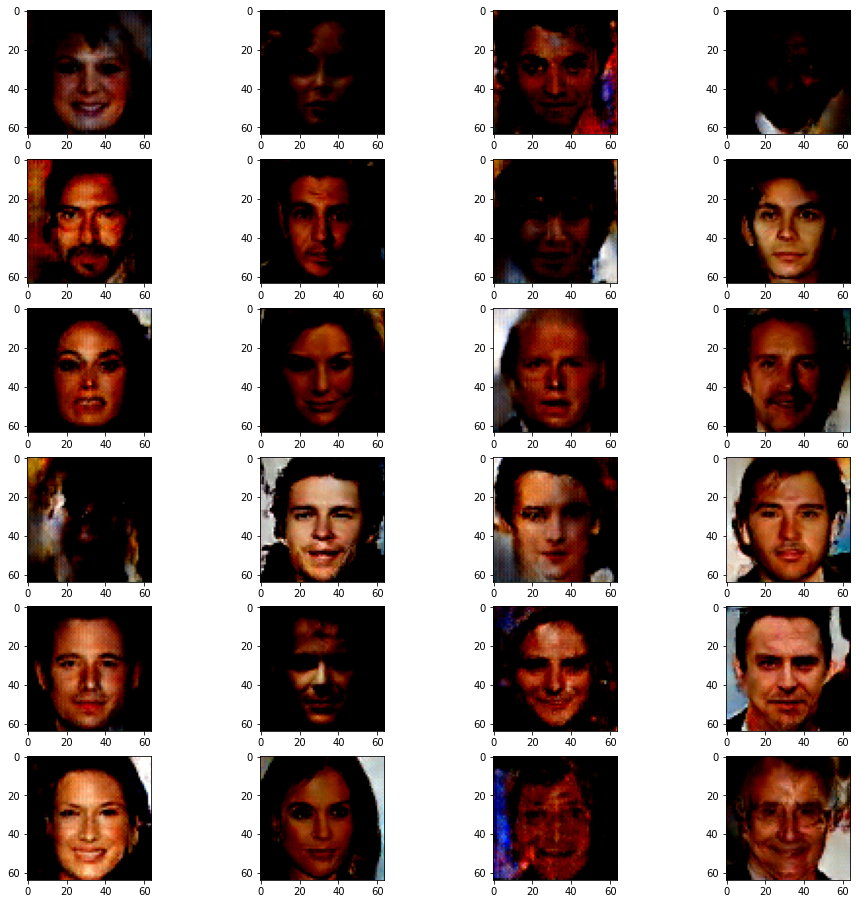

In [ ]:
### Eval our model

import matplotlib.pyplot as plt
import numpy as np

# load the embedding model
e_net, e_optimizer = get_network('e', NETWORKS_PARAMETERS, train=False)

# load our saved generator
g_net, g_optimizer = get_network('temp_gen', NETWORKS_PARAMETERS, train=False)

# load author's model
g_net_authors, g_optimizer_authors = get_network('g', NETWORKS_PARAMETERS, train=False)

########################

fig = plt.figure(figsize=(16, 16))
columns = 4
rows = 6

noise = 0.05*torch.randn(DATASET_PARAMETERS['batch_size'], 64, 1, 1)
noise = noise.cuda()

for i in range (12):
  voice, voice_label = next(voice_iterator)
  voice, voice_label = voice.cuda(), voice_label.cuda()
  embeddings = e_net(voice)
  embeddings = F.normalize(embeddings)
  # introduce some permutations
  embeddings = embeddings + noise
  embeddings = F.normalize(embeddings)

  our_fake = g_net(embeddings)
  authors_fake = g_net_authors(embeddings)

  oneFace1 = our_fake.cpu().detach()
  oneFace2 = authors_fake.cpu().detach()

  # oneFace = F.normalize(oneFace).numpy()
  oneFace1 = oneFace1.numpy()
  oneFace2 = oneFace2.numpy()
  # oneFace = oneFac2.numpy()
  face1 = oneFace1[1]
  face2 = oneFace2[1]

  new_face1 = np.ones((64, 64, 3), dtype="float32")
  new_face2 = np.ones((64, 64, 3), dtype="float32")

  new_face1[:,:, 0] = face1[0,:,:]
  new_face1[:,:, 1] = face1[1,:,:]
  new_face1[:,:, 2] = face1[2,:,:]

  new_face2[:,:, 0] = face2[0,:,:]
  new_face2[:,:, 1] = face2[1,:,:]
  new_face2[:,:, 2] = face2[2,:,:]

  fig.add_subplot(rows, columns, 2*i + 1)
  plt.imshow(new_face1)

  fig.add_subplot(rows, columns, 2*i + 2)
  plt.imshow(new_face2)

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
e_net, e_optimizer = get_network('e', NETWORKS_PARAMETERS, train=False)
# g_net, g_optimizer = get_network('g', NETWORKS_PARAMETERS, train=False)


# Pretrained model
# get the pretrained generator
pretrained_g_net, _ = get_network('g', {'g': {
        'network': Generator,
        'input_channel': 64,
        'channels': [1024, 512, 256, 128, 64], # channels for deconvolutional layers
        'output_channel': 3, # images with RGB channels
        'model_path': 'pretrained_models/generator.pth',
        
    },
  # OPTIMIZER PARAMETERS 
  'lr': 0.0002,
  'beta1': 0.5,
  'beta2': 0.999,

  # MODE, use GPU or not
  'GPU': True,
  }, train=False)

########################

fig = plt.figure(figsize=(16, 16))
columns = 4
rows = 6

for i in range (12):
  voice, voice_label = next(voice_iterator)
  voice, voice_label = voice.cuda(), voice_label.cuda()
  embeddings = e_net(voice)
  embeddings = F.normalize(embeddings)
  # introduce some permutations
  embeddings = embeddings + noise
  embeddings = F.normalize(embeddings)

  our_fake = g_net(embeddings)
  authors_fake = pretrained_g_net(embeddings)

  oneFace1 = our_fake.cpu().detach()
  oneFace2 = authors_fake.cpu().detach()

  # oneFace = F.normalize(oneFace).numpy()
  oneFace1 = oneFace1.numpy()
  oneFace2 = oneFace2.numpy()
  # oneFace = oneFac2.numpy()
  face1 = oneFace1[1]
  face2 = oneFace2[1]

  print(face.shape)
  new_face1 = np.ones((64, 64, 3), dtype="float32")
  new_face2 = np.ones((64, 64, 3), dtype="float32")

  new_face1[:,:, 0] = face1[0,:,:]
  new_face1[:,:, 1] = face1[1,:,:]
  new_face1[:,:, 2] = face1[2,:,:]

  new_face2[:,:, 0] = face2[0,:,:]
  new_face2[:,:, 1] = face2[1,:,:]
  new_face2[:,:, 2] = face2[2,:,:]

  fig.add_subplot(rows, columns, 2*i + 1)
  plt.imshow(new_face1)

  fig.add_subplot(rows, columns, 2*i + 2)
  plt.imshow(new_face2)

plt.show()


In [ ]:
fig = plt.figure(figsize=(32, 32))
columns = 4
rows = 3
for i in range(1, columns*rows +1):
    img = np.dstack((oneFace[i-1][0], oneFace[i-1][1] ,oneFace[i-1][2]))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

# Test with the Authors model

In [ ]:
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# get the pretrained generator
pretrained_g_net, _ = get_network('g', {'g': {
        'network': Generator,
        'input_channel': 64,
        'channels': [1024, 512, 256, 128, 64], # channels for deconvolutional layers
        'output_channel': 3, # images with RGB channels
        'model_path': 'pretrained_models/generator.pth',
        
    },
    # OPTIMIZER PARAMETERS 
    'lr': 0.0002,
    'beta1': 0.5,
    'beta2': 0.999,

    # MODE, use GPU or not
    'GPU': True,
    }, train=False)

embeddings = e_net(voice)
embeddings = F.normalize(embeddings)
# introduce some permutations
embeddings = embeddings + noise
embeddings = F.normalize(embeddings)
fake = pretrained_g_net(embeddings)

oneFace = fake.cpu().detach()
# oneFace = F.normalize(oneFace).numpy()
oneFace = oneFace.numpy()
# oneFace = oneFace.numpy()
face = oneFace[0]
print(face.shape)
new_face = np.ones((64, 64, 3), dtype="float32")
new_face[:,:, 0] = face[0,:,:]
new_face[:,:, 1] = face[1,:,:]
new_face[:,:, 2] = face[2,:,:]
plt.imshow(new_face)